In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024371.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024358.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024337.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024382.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024420.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024409.jpg
/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration

In [2]:
import os
import re
import glob
import pathlib
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import PIL
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle  
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

SEED=123
np.random.seed(SEED)

In [3]:
df_eda = pd.DataFrame()

classes = []
train_image_number_breakdown = {}
test_image_number_breakdown = {}
number_test_images = 0
number_train_images = 0
for class_name in os.listdir("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train"):
    classes.append(class_name)
    path = os.path.join("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train",class_name)
    count = len([entry for entry in os.listdir(path) if os.path.isfile(os.path.join(path, entry))]) 
    train_image_number_breakdown[class_name] = count
    number_train_images += count


for class_name in os.listdir("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test"):
    classes.append(class_name)
    path = os.path.join("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test",class_name)
    count = len([entry for entry in os.listdir(path) if os.path.isfile(os.path.join(path, entry))]) 
    test_image_number_breakdown[class_name] = count
    number_test_images += count

classes = list(set(classes))

In [4]:
print("Number of Train Images {}".format(number_train_images))
print("Number of Test Images {}".format(number_test_images))
print("##"*25)
print("Train Images Breakdown {}".format(train_image_number_breakdown))
print("__"*25)
print("Test Images Breakdown {}".format(test_image_number_breakdown))
print("##"*25)
print("Classes {}".format(classes))

Number of Train Images 2239
Number of Test Images 118
##################################################
Train Images Breakdown {'pigmented benign keratosis': 462, 'melanoma': 438, 'vascular lesion': 139, 'actinic keratosis': 114, 'squamous cell carcinoma': 181, 'basal cell carcinoma': 376, 'seborrheic keratosis': 77, 'dermatofibroma': 95, 'nevus': 357}
__________________________________________________
Test Images Breakdown {'pigmented benign keratosis': 16, 'melanoma': 16, 'vascular lesion': 3, 'actinic keratosis': 16, 'squamous cell carcinoma': 16, 'basal cell carcinoma': 16, 'seborrheic keratosis': 3, 'dermatofibroma': 16, 'nevus': 16}
##################################################
Classes ['basal cell carcinoma', 'squamous cell carcinoma', 'vascular lesion', 'seborrheic keratosis', 'pigmented benign keratosis', 'melanoma', 'nevus', 'dermatofibroma', 'actinic keratosis']


In [5]:
skin_df = pd.DataFrame()
classes = []
images = []
for class_name in os.listdir("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test"):
    path = os.path.join("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test",class_name)
    for image in os.listdir(path):
        classes.append(class_name)
        images.append(os.path.join(path,image))
skin_df["cell_type"] = classes
skin_df["image"] = images

In [6]:
skin_df.head(100)

,cell_type,image
0,pigmented benign keratosis,../input/skin-cancer9-classesisic/Skin cancer ...
1,pigmented benign keratosis,../input/skin-cancer9-classesisic/Skin cancer ...
2,pigmented benign keratosis,../input/skin-cancer9-classesisic/Skin cancer ...
3,pigmented benign keratosis,../input/skin-cancer9-classesisic/Skin cancer ...
4,pigmented benign keratosis,../input/skin-cancer9-classesisic/Skin cancer ...
...,...,...
95,dermatofibroma,../input/skin-cancer9-classesisic/Skin cancer ...
96,dermatofibroma,../input/skin-cancer9-classesisic/Skin cancer ...
97,dermatofibroma,../input/skin-cancer9-classesisic/Skin cancer ...
98,dermatofibroma,../input/skin-cancer9-classesisic/Skin cancer ...


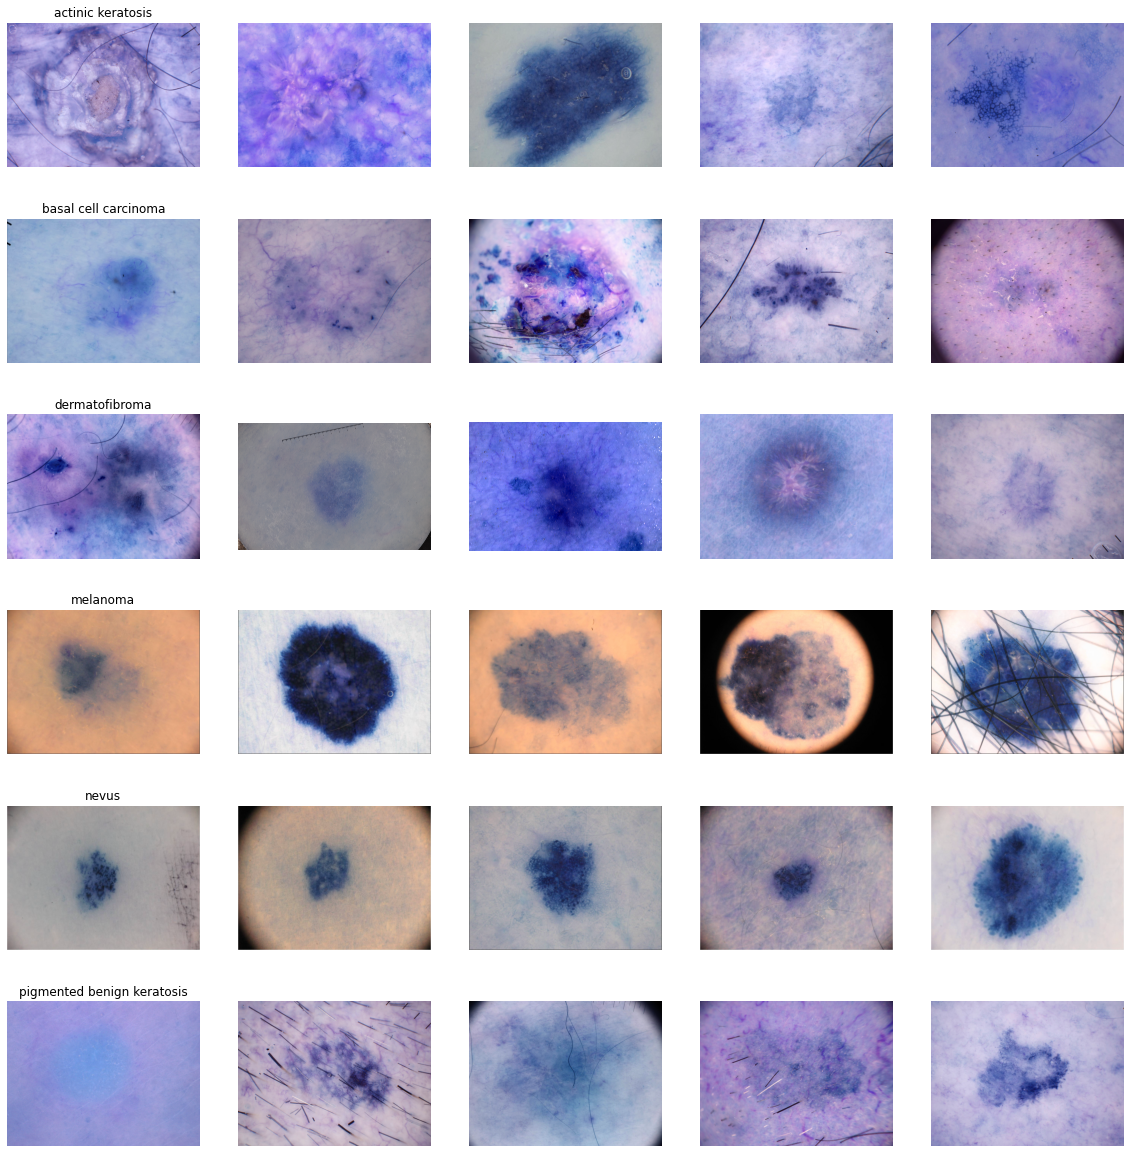

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
n_samples = 5
fig, m_axs = plt.subplots(6, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        image = cv2.imread(c_row['image'])
        #image = cv2.cvtColor(c_row['image'], cv2.COLOR_BGR2RGB)
        c_ax.imshow(image)
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

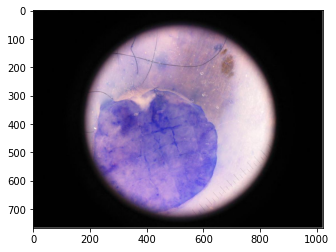

In [8]:
image = cv2.imread("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000004.jpg")
plt.imshow(image)

In [9]:
image

array([[[255, 255, 255],
        [244, 244, 244],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [243, 243, 243],
        [255, 255, 255]],

       [[241, 241, 241],
        [ 31,  31,  31],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [ 21,  21,  21],
        [233, 233, 233]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [252, 252, 252]],

       ...,

       [[255, 255, 255],
        [ 18,  18,  18],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [253, 253, 253]],

       [[229, 229, 229],
        [ 32,  32,  32],
        [  0,   0,   0],
        ...,
        [  3,   3,   3],
        [ 17,  17,  17],
        [229, 229, 229]],

       [[255, 255, 255],
        [240, 240, 240],
        [255, 255, 255],
        ...,
        [248, 248, 248],
        [241, 241, 241],
        [255, 255, 255]]

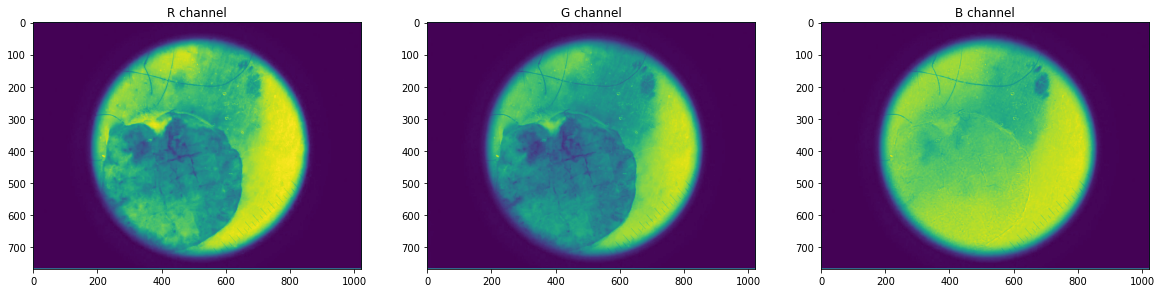

In [10]:
r = image[:,:,0]
g = image[:,:,1]
b = image[:,:,2]

# Visualize the individual color channels
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('R channel')
ax1.imshow(r)
ax2.set_title('G channel')
ax2.imshow(g)
ax3.set_title('B channel')
ax3.imshow(b)